In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d

import alphashape as ap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.dpi"] = 150

import pandas as pd
from colour import Color

In [ ]:
# Possible idea for averaging over multiple configurations
# treat the center point of each line as a particle with an
# attractive potential, and let the system equilibriate

In [2]:
# Calculates the intersection point between two finite lines (or None)
# algorithm from: jk I used this algorithm in a previous project and
# the link that I had there no longer works, so....
# Whatever, the algorithm works, so hopefully that's not a big deal
# I think it is just a generic parametric line intersection calculation
def intersection(l1, l2):
    # I have renamed the variables like this to be consistent with the source
    # above (or maybe not)
    l1 = np.array(l1)
    l2 = np.array(l2)

    x = [0, l1[0,0], l1[0,1], l2[0,0], l2[0,1]]
    y = [0, l1[1,0], l1[1,1], l2[1,0], l2[1,1]]
    
    denominator = ((x[4] - x[3])*(y[2] - y[1]) - (x[2] - x[1])*(y[4] - y[3]))
   
    s = ((x[4]-x[3])*(y[3]-y[1]) - (x[3]-x[1])*(y[4] - y[3])) / denominator

    t = ((x[2]-x[1])*(y[3]-y[1]) - (x[3]-x[1])*(y[2] - y[1])) / denominator
    
    if s >= 0 and s <= 1 and t >= 0 and t <= 1:
        intersectionPoint = [x[1] + (x[2] - x[1])*s, y[1] + (y[2] - y[1])*s]
        return intersectionPoint
    
    return None

# Computes the number of elements of lineSet that line intersects
def numLineIntersections(lineSet, line):
    count = 0
    for i in range(len(lineSet)):
        if intersection(lineSet[i], line) != None:
            count += 1
    return count
    
# This allows us to check if a point is inside a given hull (aka set of lines)
def isInsideHull(point, hullLines, padding=1000):
    # First, we extend the line up past the edge of the hull
    highestHullPoint = np.max(hullLines[:,1,0]) + padding
    
    extendedLine = np.array([[point[0], point[0]], [point[1], highestHullPoint]])
    
    intersectionCount = numLineIntersections(hullLines, extendedLine)
    
    if intersectionCount % 2 == 0:
        return False
    return True

# This method allows us to get rid of excess lines in the picture
def cullVoronoi(vor: Voronoi, communities, hullLines, boundaryPadding=500):
    
    # If we are provided a cutoff distance, we should get rid of any points that are
    # farther than that from the center of all of our points
    #mapTopLeft = [np.max(vor.points[:,0]), np.max(vor.points[:,1])]
    #mapBottomRight = [np.max(vor.points[:,0]), np.max(vor.points[:,1])]
    
    # We can't know how many lines will be good in advance, so we just
    # start with an empty array and append as we go
    goodLines = []
    
    # We iterate over all of the ridges (lines) in the voronoi tessellation
    for k, v in vor.ridge_dict.items():
        # The key will be a tuple with the indices of the two points this line divides
        # The value will be an array with the indices of the two vertices that define the line
        
        # If they are in the same community, we don't need to draw that line
        # Otherwise, we do
        if communities[k[0]] != communities[k[1]]:
            # We don't care about lines that extend to infinity, so ignore those
            if v[0] == -1 or v[1] == -1:
                pass
            else:
                # Now make sure that these vertices aren't farther than our cutoff distance
                v1 = vor.vertices[v[0]]
                v2 = vor.vertices[v[1]]

                if not isInsideHull(v1, hullLines) or not isInsideHull(v2, hullLines):
                    pass
                else:
                    goodLines.append([[v1[0], v2[0]], [v1[1], v2[1]]])

    return np.array(goodLines)

None


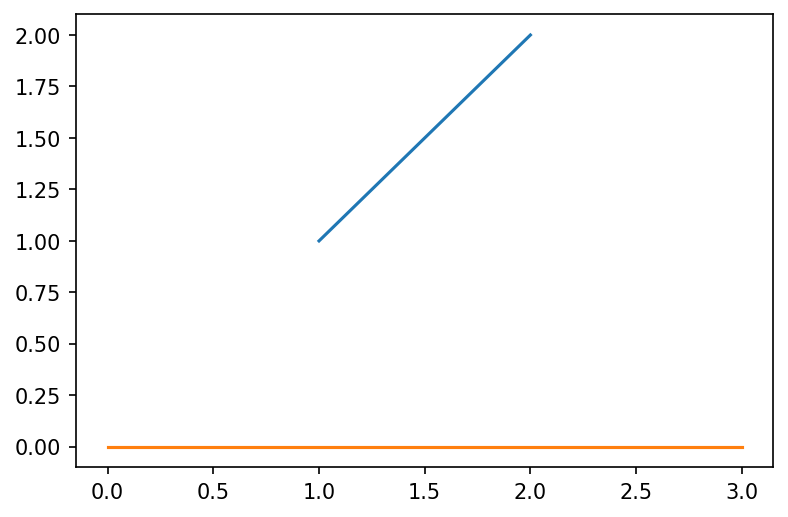

In [95]:
l1 = [[1, 2], [1, 2]]
l2 = [[3, 0], [0, 0]]

plt.plot(l1[0], l1[1])
plt.plot(l2[0], l2[1])

print(intersection(l2, l1))
plt.show()

In [3]:
# Some methods to help visualize things
def drawPoints(ax, pointArr, communities, colors):
    for i in range(len(points)):
        ax.scatter(pointArr[i,0], pointArr[i,1], color=colors[communities[i]-1])
        
def drawLines(ax, lines, color='black', opacity=1):
    for i in range(len(lines)):
        ax.plot(lines[i,0], lines[i,1], c=color, alpha=opacity)

def genRandomColors(seed=21):
    np.random.seed(seed)
    
    def rgb_to_hex(rgb):
        return '%02x%02x%02x' % rgb

    randomColors = [f"#{rgb_to_hex(tuple(np.random.choice(range(256), size=3).flatten()))}" for i in range(max(communities))]

    return randomColors

In [3]:
communities = np.genfromtxt("communities.csv", dtype=int)

In [4]:
# Now read in the data
dataFrame = pd.read_csv("Location_20.csv")

# Generate the voronoi tesselation
points = np.zeros([len(dataFrame["x"]), 2])
points[:,0] = dataFrame["x"]
points[:,1] = dataFrame["y"]

mapVor = Voronoi(points)

In [25]:
# Find the total boundary around the shape
alpha = 0.95 * ap.optimizealpha(points)
hull = ap.alphashape(points, alpha)
hullPoints = hull.exterior.coords.xy

print(hullPoints)

(array('d', [643030.791578322, 643058.987941372, 642985.742849943, 642981.537216177, 642935.890898179, 642872.93244639, 642820.142653981, 642777.869663758, 642707.826831729, 642658.763199515, 642603.808291915, 642555.813104138, 642529.331063347, 642493.872232729, 642419.071262989, 642368.051927469, 642323.679887695, 642282.086573942, 642243.2146794, 642199.666802968, 642139.23735673, 642119.91611654, 642060.718234192, 642011.159731686, 641950.696247848, 641889.007175495, 641889.383182494, 641817.176805472, 641770.770383383, 641719.579743401, 641646.618804792, 641612.308099875, 641553.183906953, 641509.687398551, 641458.660692139, 641405.893779165, 641374.46245093, 641320.199359785, 641283.914241358, 641248.642145832, 641197.095014089, 641135.905993551, 641091.864373282, 641102.721737342, 641049.12859516, 641001.989775189, 640952.17744972, 640904.105225502, 640854.768354575, 640821.523090155, 640770.893263509, 640759.855926693, 640717.240259517, 640660.196219627, 640617.951753286, 64056

True


<ipython-input-107-75f31af8cc08>:14: RuntimeWarning: divide by zero encountered in double_scalars
  s = ((x[4]-x[3])*(y[3]-y[1]) - (x[3]-x[1])*(y[4] - y[3])) / denominator
<ipython-input-107-75f31af8cc08>:16: RuntimeWarning: invalid value encountered in double_scalars
  t = ((x[2]-x[1])*(y[3]-y[1]) - (x[3]-x[1])*(y[2] - y[1])) / denominator


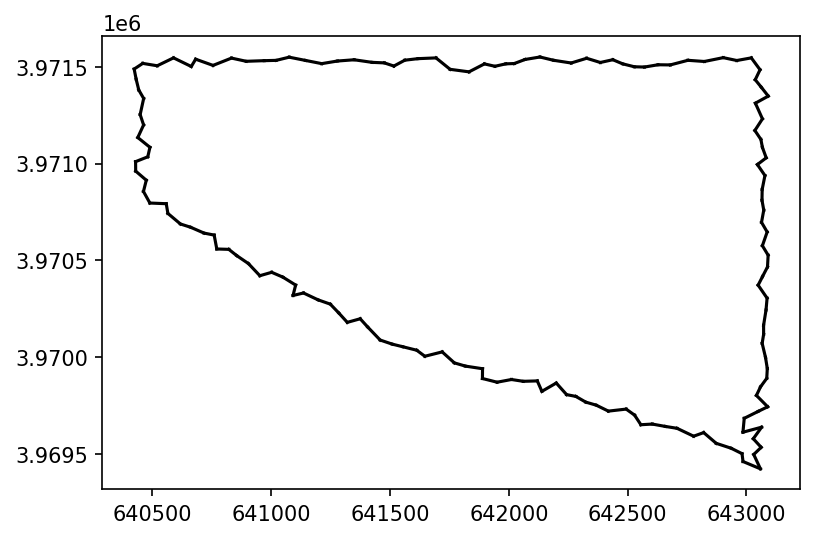

In [108]:
#hullPoints = [hullPoints[0].tolist(), hullPoints[1].tolist()]
hullLines = np.zeros([len(hullPoints[0]), 2, 2])

for i in range(len(hullPoints[0])):
    hullLines[i] = [[hullPoints[0][i], hullPoints[0][(i+1)%len(hullPoints[0])]],
                    [hullPoints[1][i], hullPoints[1][(i+1)%len(hullPoints[0])]]]
    
#print(hullLines)
fig, ax = plt.subplots()

drawLines(ax, hullLines, 'black')
#drawLines(ax, isInsideHull([6.415e5, 3.9710e6], hullLines), 'blue')
print(isInsideHull([6.415e5, 3.9710e6], hullLines))
plt.show()

<ipython-input-107-75f31af8cc08>:14: RuntimeWarning: divide by zero encountered in double_scalars
  s = ((x[4]-x[3])*(y[3]-y[1]) - (x[3]-x[1])*(y[4] - y[3])) / denominator
<ipython-input-107-75f31af8cc08>:16: RuntimeWarning: invalid value encountered in double_scalars
  t = ((x[2]-x[1])*(y[3]-y[1]) - (x[3]-x[1])*(y[2] - y[1])) / denominator


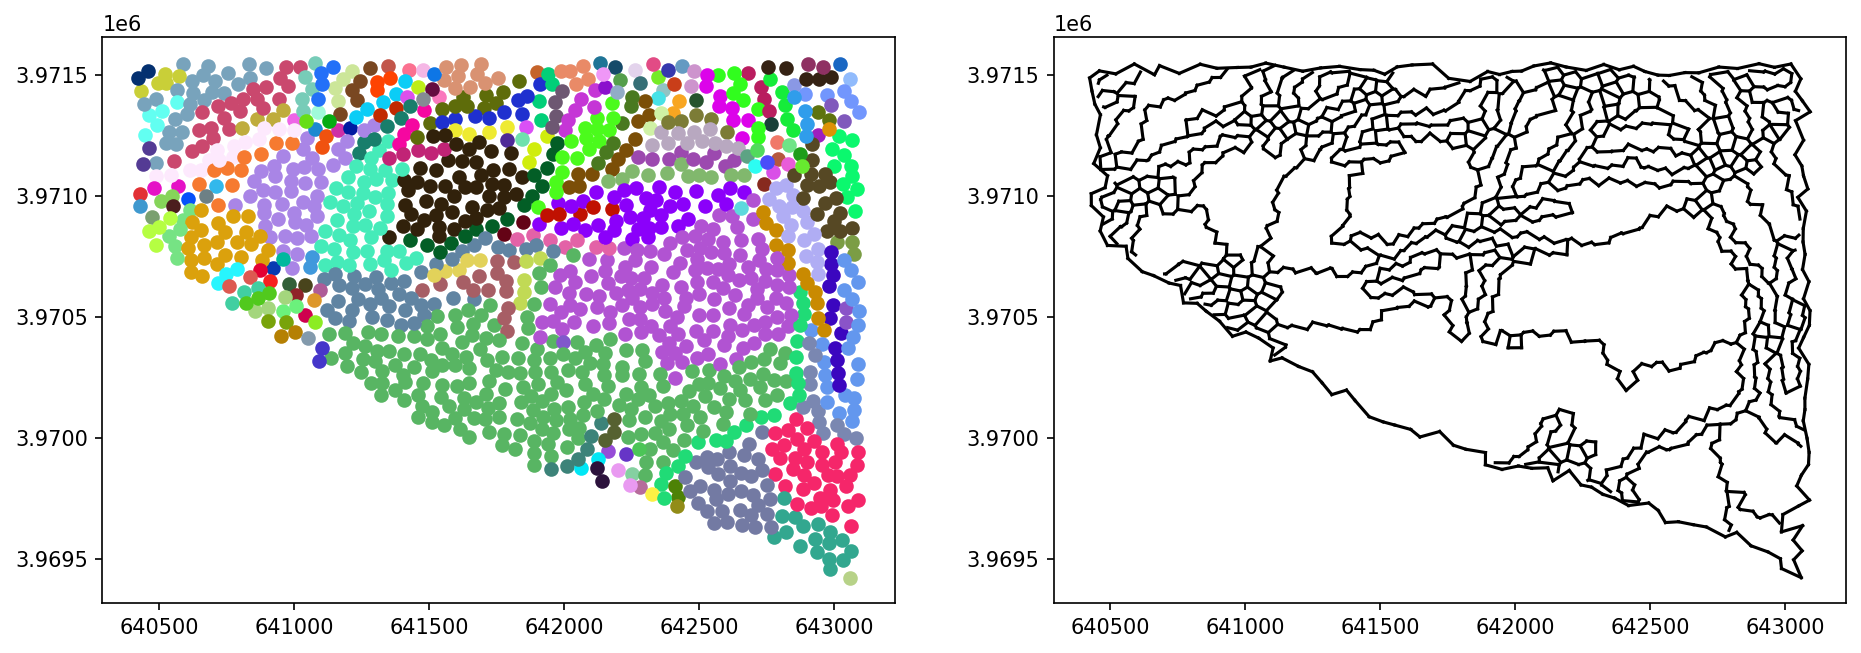

In [114]:
# Now show everything
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

randomColors = genRandomColors()

# On the left, we plot just the points
drawPoints(ax[0], points, communities, randomColors)

# On the right, we draw the boundaries
boundaryLines = cullVoronoi(mapVor, hullLines)
drawLines(ax[1], boundaryLines, 'black')
drawLines(ax[1], hullLines, 'black')
#ax[0].set_xticks([])
#ax[0].set_yticks([])
#ax[1].set_xticks([])
#ax[1].set_yticks([])

plt.savefig('VoronoiBoundary.png')
plt.show()

<ipython-input-107-75f31af8cc08>:14: RuntimeWarning: divide by zero encountered in double_scalars
  s = ((x[4]-x[3])*(y[3]-y[1]) - (x[3]-x[1])*(y[4] - y[3])) / denominator
<ipython-input-107-75f31af8cc08>:16: RuntimeWarning: invalid value encountered in double_scalars
  t = ((x[2]-x[1])*(y[3]-y[1]) - (x[3]-x[1])*(y[2] - y[1])) / denominator


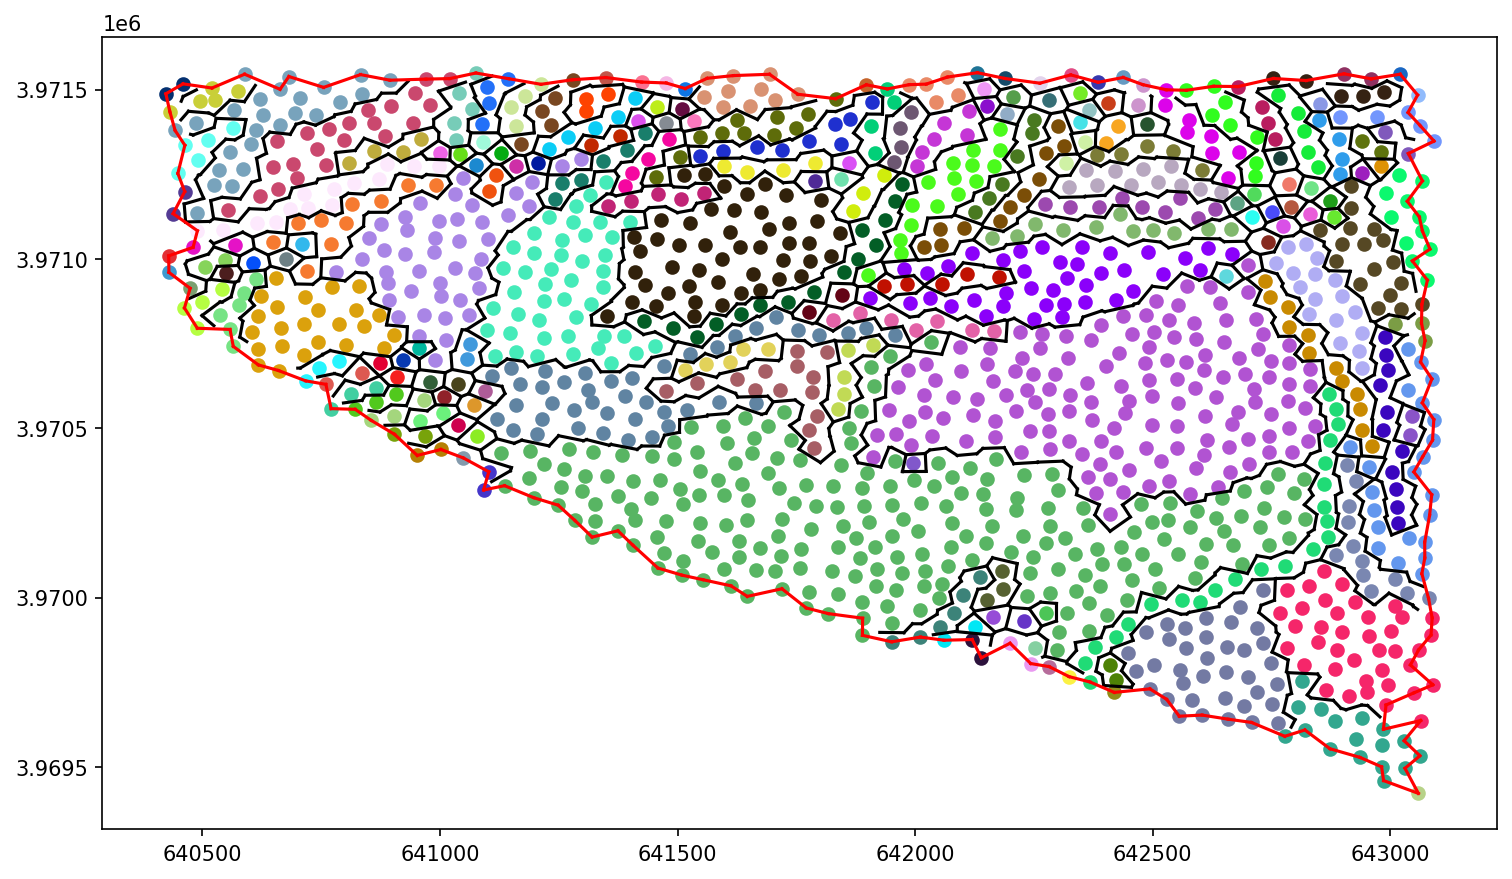

In [112]:
# Now show everything
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

randomColors = genRandomColors()

# On the left, we plot just the points
drawPoints(ax, points, communities, randomColors)

# On the right, we draw the boundaries
boundaryLines = cullVoronoi(mapVor, hullLines)
drawLines(ax, boundaryLines, 'black')
drawLines(ax, hullLines, 'red')
#ax[0].set_xticks([])
#ax[0].set_yticks([])
#ax[1].set_xticks([])
#ax[1].set_yticks([])

plt.show()